In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from tqdm.auto import tqdm
import pandahouse as ph
import pandasql as ps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Настройка графиков
sns.set(
    font_scale=.8,
    style='whitegrid',
    rc={'figure.figsize': (5, 4)}
)

# Задание 1 (A/B)
## Условие
A/B тест - новая механика оплаты услуг на сайте (предполагается онлайн-магазин) \
Нужно ли запускать на всех пользователях?
## Требования
1) Использовать язык программирования Python  
2) Комментарии к действиям  
3) Законченный отчёт с выводами

## Данные

**groups.csv (ids_df)** - инфа о принадлежности пользователя группе (A/B)

In [4]:
# get_url = 'https://getfile.dokpub.com/yandex/get/'
# url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
# ids_df = pd.read_csv(get_url + url, sep=';')

ids_df = pd.read_csv('groups.csv', sep=';')

In [5]:
ids_df

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


- A - контрольная группа
- B - тестовая группа

**group_add.csv (ids_add_df)**  - дополнительные пользователи к groups.csv

In [6]:
ids_add_df = pd.read_csv('group_add.csv', sep=',')

In [7]:
ids_add_df

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


**active_studs.csv (users_df)** - инфа по пользователям, которые зашли на платформу в дни проведения эксперимента

In [8]:
users_df = pd.read_csv('active_studs.csv')

In [9]:
users_df.rename(columns={'student_id': 'id'}, inplace=True)

In [10]:
users_df

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


**checks.csv (checks_df)** - инфа об оплатах пользователей в дни проведения эксперимента

In [11]:
checks_df = pd.read_csv('checks.csv', sep=';')

Предполагается, что в таблице указаны те же id пользователей, что были в active_studs.csv

In [12]:
checks_df.rename(columns={'student_id': 'id'}, inplace=True)

In [13]:
checks_df

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


## Разведочный анализ

### Качество данных

#### Типы данных

In [14]:
ids_df.dtypes

id      int64
grp    object
dtype: object

In [15]:
ids_add_df.dtypes

id      int64
grp    object
dtype: object

In [16]:
users_df.dtypes

id    int64
dtype: object

In [17]:
checks_df.dtypes

id       int64
rev    float64
dtype: object

#### Дубли по id

In [18]:
ids_df.id.nunique() - ids_df.id.count()

0

In [19]:
ids_add_df.id.nunique() - ids_add_df.id.count()

0

In [20]:
users_df.id.nunique() - users_df.id.count()

0

In [21]:
checks_df.id.nunique() - checks_df.id.count()

0

Дублей id в исходных df нет

In [22]:
ids_all_df = pd.concat([ids_df, ids_add_df])  # Все id

In [23]:
ids_all_df

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [24]:
# Проверка
ids_df.id.count() + ids_add_df.id.count()

74576

In [25]:
ids_all_df.id.nunique() - ids_all_df.id.count()

0

Дублей id нет

#### Наличие инфы по дополнительным id

In [26]:
ids_add_df.merge(users_df, on='id').shape[0]

13

In [27]:
ids_add_df.merge(checks_df, on='id').shape[0]

1

Информация по входам/транзакциям дополнительных пользователей имеется

#### В рядах пользователей лишь известные id?

In [28]:
users_df.shape[0]

8341

C учётом того, что дублей id в df нет

In [29]:
users_df.merge(ids_all_df, on='id').shape[0]

8341

В рядах пользователей лишь известные id!

#### Покупки совершали лишь известные пользователи?

In [30]:
checks_df.shape[0]

541

C учётом того, что дублей id в df нет

In [31]:
checks_df.merge(users_df, on='id').shape[0]

392

Покупки совершались под id, которые не указаны в df с пользователями

id, которые отсутствуют в списке пользователей, но присутствуют в чеках

In [32]:
# id, которые присутствуют в списке пользователей и чеках
good_ids = checks_df.merge(users_df, on='id').id.to_list()
anomaly_ids_df = (
    checks_df
    .merge(users_df, on='id', how='left')
    .query('id not in @good_ids')
)
anomaly_ids_df

,id,rev
1,3185,690.0
2,25973,690.0
3,26280,690.0
5,100645,630.0
6,102534,580.0
...,...,...
508,5291900,199.0
512,5331842,290.0
521,5486319,199.0
530,5562806,398.0


In [33]:
# Проверка
checks_df.merge(users_df, on='id').shape[0] + anomaly_ids_df.shape[0] - checks_df.shape[0]

0

Проверка, что для всех аномальных покупок указана выручка

In [34]:
anomaly_ids_df.rev.isna().sum()

0

Следовательно, имеются аномальные покупки (с id пользователей, которые не заходили в день проведения эксперимента). При этом для всех аномальных покупок указана выручка

#### Есть ли эти аномальные id в исходном списке?

C учётом того, что дублей id в df нет

In [35]:
ids_all_df.merge(anomaly_ids_df, on='id')

,id,grp,rev
0,3185,B,690.0
1,25973,B,690.0
2,26280,B,690.0
3,100645,B,630.0
4,102534,B,580.0
...,...,...,...
144,5291900,B,199.0
145,5331842,B,290.0
146,5486319,B,199.0
147,5562806,B,398.0


In [36]:
anomaly_ids_df.id.nunique()

149

Все аномальные id есть в исходном списке

In [37]:
ids_df.merge(anomaly_ids_df, on='id')

,id,grp,rev
0,3185,B,690.0
1,25973,B,690.0
2,26280,B,690.0
3,100645,B,630.0
4,102534,B,580.0
...,...,...,...
144,5291900,B,199.0
145,5331842,B,290.0
146,5486319,B,199.0
147,5562806,B,398.0


Все аномальные id находятся в списке id до их дополнения (в groups.csv)

In [38]:
ids_add_df.merge(anomaly_ids_df, on='id')

,id,grp,rev


In [39]:
ids_df.merge(anomaly_ids_df, on='id').groupby('grp').id.count()

grp
A     29
B    120
Name: id, dtype: int64

Все аномальные id присутствуют в исходном списке (имеются как в контрольной, так и в тестовой выборке) => скорее всего система записи пользователей (зашедших в день эксперимента) работает некорректно (предполагается, что корректность записи чеков можно определить сравнением дохода по checks_df и финансовому отчёту за данный период)

Вывод: использовать users_df нецелесообразно (например, для  расчёта метрики CR в покупку)

### Информационная нагрузка в данных

C учётом того, что дублей id в df нет

#### Размеры групп по id

In [40]:
id_grp_size = (
    ids_all_df.groupby('grp').id.count()
    .to_frame().rename(columns={'id': 'size'})
)
id_grp_size

,size
grp,
A,14693
B,59883


In [41]:
float((id_grp_size.loc['A'] / id_grp_size.loc['B']).round(3))
# A / B =

0.245

In [42]:
# Проверка
int(id_grp_size.sum()) - int(ids_all_df.id.count())

0

#### Размеры групп по пользователям

In [43]:
user_grp_size = (
    ids_all_df.merge(users_df)
    .groupby('grp').id.count()
    .to_frame().rename(columns={'id': 'size'})
)
user_grp_size

,size
grp,
A,1538
B,6803


In [44]:
float((user_grp_size.loc['A'] / user_grp_size.loc['B']).round(3))
# A / B =

0.226

In [45]:
# Проверка
int(user_grp_size.sum()) - int(users_df.id.count())

0

#### Размеры групп по клиентам

In [46]:
client_grp_size = (
    ids_all_df.merge(checks_df)
    .groupby('grp').id.count()
    .to_frame().rename(columns={'id': 'size'})
)
client_grp_size

,size
grp,
A,107
B,434


In [47]:
float((client_grp_size.loc['A'] / client_grp_size.loc['B']).round(3))
# A / B =

0.247

In [48]:
# Проверка
int(client_grp_size.sum()) - int(checks_df.id.count())

0

Вывод: контрольная группа, представленная в df ~ в 4 раза меньше, чем тестовая (что странно - мб снижение мощности тестов)

#### Описательная статистика клиентов

In [49]:
clients_df = checks_df.merge(ids_all_df, on='id')
clients_df

,id,rev,grp
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B
...,...,...,...
536,5645737,1900.0,B
537,5651566,1900.0,B
538,5662322,1900.0,B
539,5681918,1900.0,B


Контрольная группа

In [50]:
clients_a_df = clients_df.query('grp == "A"')
clients_a_df.describe()

,id,rev
count,1.070000e+02,107.000000
mean,2.576894e+06,860.710280
std,1.793022e+06,815.893445
min,1.627000e+03,199.000000
25%,9.773465e+05,290.000000
50%,2.480939e+06,690.000000
75%,4.289137e+06,990.000000
max,5.577840e+06,3660.000000


Тестовая группа

In [51]:
clients_b_df = clients_df.query('grp == "B"')
clients_b_df.describe()

,id,rev
count,4.340000e+02,434.000000
mean,2.499456e+06,1108.824893
std,1.711912e+06,741.834304
min,3.185000e+03,199.000000
25%,9.935570e+05,420.750000
50%,2.526589e+06,935.000000
75%,3.956213e+06,1900.000000
max,5.740903e+06,4650.000000


- средний/медианный чек больше у тестовой группы

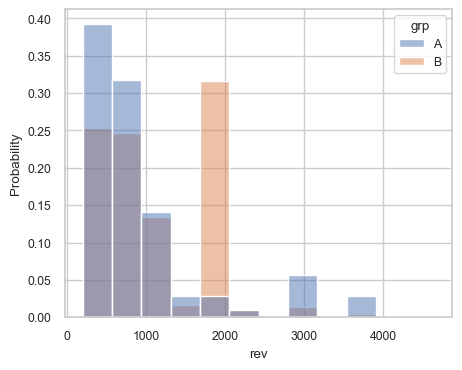

In [52]:
sns.histplot(data=clients_df, x='rev', hue='grp', stat='probability', common_norm=False);

- распределения имеют НЕ нормальный вид
- распределение B не логнормальное (логарифмировать смысла нет)
- заметна значительная разица распределений для rev ~2000 (что странно, но аномалии замечено не было)

In [53]:
# Аномальные чеки для тестовой выборки
ids_all_df.merge(anomaly_ids_df, on='id').query('grp == "B"').groupby('rev', as_index=False).id.count()

,rev,id
0,199.0000,12
1,290.0000,18
2,398.0000,1
3,580.0000,4
4,630.0000,1
5,690.0000,46
6,840.0000,3
7,990.0000,18
8,1140.0000,11
9,1180.0000,1


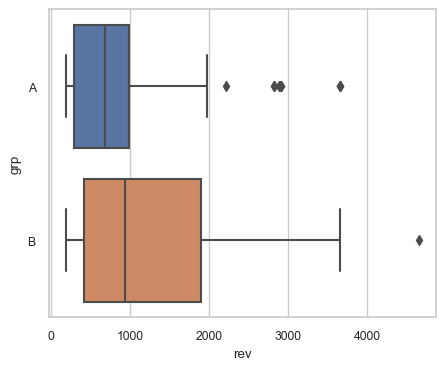

In [54]:
sns.boxplot(data=clients_df, x='rev', y='grp');

- имеются потенциальные выбросы

Проверка на гомогенность дисперсий выборок

In [55]:
ss.levene(clients_a_df.rev, clients_b_df.rev)

LeveneResult(statistic=4.478900854248498, pvalue=0.03477352573759214)

- p-value < 0.05 => дисперсии распределений неоднородны

Уникальные значения выручки по чекам в группах

In [56]:
print(f"Контрольная.\t Всего: {clients_a_df.rev.count()}. Уникальных: {clients_a_df.rev.nunique()}")
print(f"Тестовая.\t Всего: {clients_b_df.rev.count()}. Уникальных: {clients_b_df.rev.nunique()}")

Контрольная.	 Всего: 107. Уникальных: 23
Тестовая.	 Всего: 434. Уникальных: 35


## A/B тест
### План
1) Какие метрики выбрать для сравнения?  

2) Имеются ли различия в группах? Возможные причины?  

3) Являются ли различия статистически значимыми?  

4) Стоит ли запускать новую механику на всех пользователей?  


### 1) Какие метрики выбрать для сравнения?
Основная цель компании - увеличение прибыли  
Модель юнит-экономики:  
$MarginalProfit = Users * CR * (ARPPU * margin - CAC)$ 

Неизменные в эксперименте метрики:
- $Users$ - изменение механики оплаты с большой вероятностью не отразится на количестве пользователей, которые заходят на сайт
- $margin$ - изменение механики оплаты никак не влияет на цену и себестоимость товаров
- $CAC$ - изменение механики оплаты не связано с расходами на привлечение клиентов

Метрики, которые могли повлиять на $MarginalProfit$:
- $ARPPU$ (и связанные с ней)
- $CR$ в покупку (и связанные с ней)

Метрика $CR$ в покупку не подходит для анализа, тк предполагается ошибка в составлении df с пользователями, зашедшими в день эксперимента

### 2,3) Имеются ли статзначимые различия в группах? Причины
- Распределения чеков в группах имеют ощутимое количество повторов (особенно в тестовой) => применение теста Манна-Уитни является сомнительной идеей  
- Обычный t-тест неприменим в силу неоднородности дисперсий
- t-тест с поправкой Уэлча может быть неприменим в силу наличия потенциальных выбросов

Поэтому наиболее оптимальным вариантом для сравнения групп видится bootstrap

In [57]:
def bootstrap_test(
    s1,
    s2,
    n_ss=5000,
    statistic_func=np.mean,
    conf_level=0.95,
    hist_n_bins=100,
    p_val_evaluation=False,
    print_info=True
):
    '''
    Функция для проверки гипотез с помощью bootstrap
    
    Parameters
    ----------
    s1: pandas.Series
        Выборка 1
    s2: pandas.Series
        Выборка 2
    n_ss: int, default 5000
        Количество bootstrap подвыборок (bootstrab subsamples)
        bootstrap подвыборка - подвыборка с повторениями
    statistic_func: function, default np.mean
        Функция для вычисления интересующей статистики
    conf_level: float, default 0.95
        Уровень значимости
    hist_n_bins: int, default 100
        Количество столбиков для гистограммы
    p_val_evaluation: bool, default False
        Оценка p-value с помощью нормального распределения
    print_info: bool, default True
        Вывод на экран информации (в т.ч. красивого графика)
        
    Returns
    -------
    is_0_in_ci: bool
        Находится ли 0 в ДИ
    boot_data: pandas.Series
        Расрпределение разницы метрик бутстрап выборок
    quantiles: dict
        Словарь с квантилями
    '''
    # Размер бутстрап подвыборок
    ss1_size = len(s1)
    ss2_size = len(s2)
    
    # Распределение разницы статистик подвыборок
    boot_data = []
    if print_info:
        for i in tqdm(range(n_ss)):  # извлекаем подвыборки
            ss1 = s1.sample(ss1_size, replace=True).values
            ss2 = s2.sample(ss2_size, replace=True).values
            boot_data.append(statistic_func(ss1)-statistic_func(ss2))
    else:
        for i in range(n_ss):  # извлекаем подвыборки
            ss1 = s1.sample(ss1_size, replace=True).values
            ss2 = s2.sample(ss2_size, replace=True).values
            boot_data.append(statistic_func(ss1)-statistic_func(ss2))
    
    boot_data = pd.Series(boot_data)
    
    # Вычисление квантилей
    left_quant = (1 - conf_level) / 2
    right_quant = 1 - left_quant
    quantiles = boot_data.quantile([left_quant, right_quant])
    quantiles.columns = ['value']
    
    # Статзначимость отличий выборок
    if quantiles.iloc[0] < 0 <= quantiles.iloc[1]:
        is_0_in_ci = True
    else:
        is_0_in_ci = False
    
    # Вычисление p-value 
    # (из предположения, что распределение разницы статистик подвыборок - нормальное)
    if p_val_evaluation:
        p_1 = st.norm.cdf(
            x=0,
            loc=boot_data.mean(), 
            scale=boot_data.std()
        )
        p_2 = st.norm.cdf(
            x=0, 
            loc=-boot_data.mean(),
            scale=boot_data.std()
        )
        p_value = min(p_1, p_2) * 2  # Двустороння вероятность нулевых отличий распределений
        
    # Визуализация
    if print_info:
        hist_ys = []
        _, _, bars = plt.hist(boot_data, bins=hist_n_bins)
        for bar in bars:
            hist_ys.append(bar.get_height())
            bar.set_edgecolor('black')
            if quantiles.iloc[0] < bar.get_x() <= quantiles.iloc[1]:
                # Столбик в ДИ
                bar.set_facecolor('grey')
            else: 
                bar.set_facecolor('red')
        plt.style.use('ggplot')
        plt.vlines(quantiles, ymin=0, ymax=max(hist_ys), linestyle='--', colors='black')  # Отображение квантилей
        if quantiles.iloc[0] < 0 <= quantiles.iloc[1]:  # Подсветка нуля
            plt.vlines(0, ymin=0, ymax=max(hist_ys), colors='green')
        else:
            plt.vlines(0, ymin=0, ymax=max(hist_ys), colors='red')
        plt.xlabel('metric difference')
        plt.ylabel('frequency')
        plt.title("Subsamples metric difference")
        plt.show()
        if p_val_evaluation:
            print(f'p-value: {p_value}')
    
    return is_0_in_ci, boot_data, quantiles

  0%|          | 0/5000 [00:00<?, ?it/s]

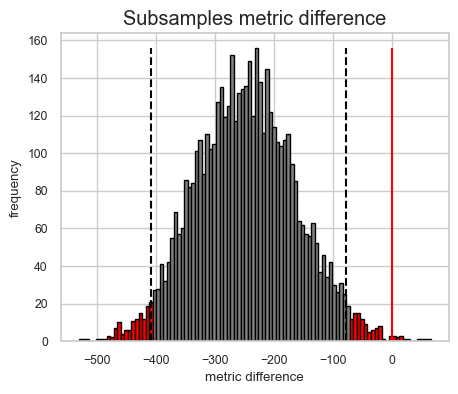

In [58]:
_ = bootstrap_test(
    clients_a_df.rev,
    clients_b_df.rev
)

Как можно видеть имеются статзначимые различия в ARPPU между выборками

In [59]:
clients_b_df.rev.mean() - clients_a_df.rev.mean()

248.11461271372616

### 4) Выводы
- средний чек (ARPPU) больше в тестовой выборке
- корректно оценить CR с текущими данными не представляется возможным
- если CR ~ не изменился (или увеличился), то запускать новую механику на всех пользователей стоит
- в идеале повторить эксперимент после проведения дополнительных исследований

#### Необходимы дополнительные исследования
- выяснить причину превосходства размера тестовой выборки над контрольной в несколько раз
- провести исследование работы системы фиксации активности пользователя в период проведения эксперимента, т.к. скорее всего она работает некорректно (active_studs.csv)

# Задание 2 (SQL)

## 2.1. Очень усердные ученики
### Условие
#### Преамбола
- Имеется образовательный курс
- Каждое задание курса - "горошина"
- очень усердный ученик - который за текущий месяц правильно решил 20 и более "горошин"

#### Суть
- Написать оптимальный запрос, который даст информацию о количестве очень усердных учеников

### Данные
#### Загрузка

In [60]:
# # Через удалённый доступ к clickhouse
# connection = {# Параметры для подключения к clickhouse
#     'host': 'http://clickhouse.beslan.pro:8080',
#     'database': 'default',
#     'user': 'student', 
#     'password': 'dpo_python_2020'
# }
# query = """
# SELECT
#     st_id,
#     CAST(timest AS DateTime) AS timest,
#     correct,
#     subject
# FROM peas
# """
# peas_df = ph.read_clickhouse(query, connection=connection)
# # peas_df.to_csv('peas.csv', index=False)

In [61]:
peas_df = pd.read_csv('peas.csv')
peas_df

,Unnamed: 0,st_id,timest,correct,subject
0,0,100379,2021-10-30 13:32:29,1,Theory of probability
1,1,100379,2021-10-30 14:11:19,0,Vizualization
2,2,100379,2021-10-30 15:54:22,1,Theory of probability
3,3,100379,2021-10-30 16:44:50,1,Vizualization
4,4,100379,2021-10-30 17:15:05,1,Theory of probability
...,...,...,...,...,...
13240,13240,996911,2021-10-31 08:41:00,1,Statistics
13241,13241,996911,2021-10-31 09:12:28,0,Statistics
13242,13242,996911,2021-10-31 09:33:39,0,Statistics
13243,13243,996911,2021-10-31 09:46:44,1,Statistics


- st_id - ID ученика
- temest - время решения карточки
- correct - правлиьность решения "горошины"
- subject - дисциплина, в которой находится "горошина"

### Решение
#### Решение SQL

Имеющиеся в таблице данные

In [62]:
query = """
SELECT
    st_id,
    CAST(timest AS DateTime) AS timest,
    correct,
    subject
FROM peas_df
ORDER BY timest DESC
"""
ps.sqldf(query)

,st_id,timest,correct,subject
0,100379,2021,1,Theory of probability
1,100379,2021,0,Vizualization
2,100379,2021,1,Theory of probability
3,100379,2021,1,Vizualization
4,100379,2021,1,Theory of probability
...,...,...,...,...
13240,996911,2021,1,Statistics
13241,996911,2021,0,Statistics
13242,996911,2021,0,Statistics
13243,996911,2021,1,Statistics


Данные представлены лишь за один месяц

Оптимальный запроос:

In [63]:
query = """
SELECT
    SUM(flags) AS diligence_st
FROM
(
    SELECT 
        SUM(correct) >= 20 AS flags
    FROM peas_df
    GROUP BY st_id
)
"""
ps.sqldf(query)

,diligence_st
0,136


## 2.2. Оптимизация воронки
### Условие
- есть образовательная платформа
- модель trial (бесплатная) - ограничение в 30 "горошин" в день
- полный доступ - доступ к неограниченному количеству "горошин"
- активный пользователь - который решил больше 10 задач правильно в любых дисциплинах
- активный пользователь по математике - который за всё время решил 2 и более задач по математике

### Задание
В одном запросе выгрузить информацию по группам пользователей:
- ARPU
- ARPAU
- CR в покупку
- CR активного пользователя в покупку
- CR пользователя из активности по математике (subject='math') в покупку курса по математике

### Данные

In [64]:
studs_df = pd.read_csv('studs.csv')
studs_df

,Unnamed: 0,st_id,test_grp
0,0,100379,pilot
1,1,101432,control
2,2,104818,pilot
3,3,104885,pilot
4,4,104966,pilot
...,...,...,...
595,595,988626,pilot
596,596,993249,pilot
597,597,994983,pilot
598,598,996911,control


- test_grp - метка ученика в эксперименте

In [65]:
final_project_check_df = pd.read_csv('final_project_check.csv')
final_project_check_df

,Unnamed: 0,st_id,sale_time,money,subject
0,0,101432,2021-10-31 04:44:32,85000,Math
1,1,101432,2021-10-31 12:43:50,65000,Vizualization
2,2,104885,2021-10-30 17:05:55,65000,Vizualization
3,3,104885,2021-10-30 22:49:33,75000,Statistics
4,4,106464,2021-10-31 13:17:13,85000,Math
...,...,...,...,...,...
56,56,969595,2021-10-30 23:54:52,65000,Vizualization
57,57,969595,2021-10-31 02:02:07,75000,Statistics
58,58,969595,2021-10-31 10:07:04,100000,Python
59,59,976866,2021-10-30 16:20:17,85000,Math


- sale_time - время покупки курса
- money - цена курса

### Разведочный анализ
#### Проверка на уникальность id

In [66]:
peas_df.shape[0]

13245

In [67]:
peas_df.st_id.nunique()

308

308 учеников суммарно решили 13245 задач (правильно/нет)

In [68]:
studs_df.shape[0] - studs_df.st_id.nunique()

0

Все st_id в studs_df уникальны

In [69]:
final_project_check_df.shape[0]

61

In [70]:
final_project_check_df.st_id.nunique()

47

47 учеников суммарно купили 61 курс => некоторые купили несколько курсов

#### Проверка таблиц на непротиворечивость 

In [71]:
active_studs_df = peas_df.groupby('st_id').head(1)
active_studs_df

,Unnamed: 0,st_id,timest,correct,subject
0,0,100379,2021-10-30 13:32:29,1,Theory of probability
47,47,101432,2021-10-30 13:14:00,1,Theory of probability
75,75,104885,2021-10-30 16:51:48,0,Python
85,85,104966,2021-10-30 14:43:43,0,Vizualization
132,132,106464,2021-10-30 13:16:47,0,Math
...,...,...,...,...,...
13065,13065,986680,2021-10-30 16:53:23,0,Statistics
13097,13097,986894,2021-10-30 13:41:28,1,Python
13102,13102,988102,2021-10-30 13:11:19,1,Math
13119,13119,994983,2021-10-30 13:24:13,0,Vizualization


In [72]:
studs_df.merge(active_studs_df, on='st_id').shape

(308, 7)

Все ученики, приступавшие к заданиям имеются в списке учеников

In [73]:
client_checks_df = final_project_check_df.groupby('st_id', as_index=False).money.sum()
client_checks_df.shape

(47, 2)

In [74]:
studs_df.merge(client_checks_df, on='st_id').shape

(47, 4)

Все клиенты имеются в списке учеников

#### Купившие курсы без выполнения заданий

In [75]:
client_checks_df.merge(active_studs_df, on='st_id', how='left').correct.isna().sum()

2

2 ученика покупали курсы, не приступав к заданиям

#### Группы пользователей

In [76]:
studs_df.test_grp.unique()

array(['pilot', 'control'], dtype=object)

### Решение SQL

In [82]:
query = """
WITH
    user_checks AS
    (
        -- Таблица с чеками пользователей
        SELECT
            st_id,
            MIN(grp) AS grp,
            SUM(item_money) AS money,
            SUM(item_money) > 0 AS bool_money -- Для расчёта CR
        FROM
        (
            -- Таблица с расширенной инфой по ученикам (купленные курсы)
            SELECT
                s.st_id AS st_id,
                s.test_grp AS grp,
                COALESCE(f.money, 0) AS item_money
            FROM studs_df AS s
            LEFT JOIN final_project_check_df AS f
                ON s.st_id = f.st_id
        )
        GROUP BY st_id
    ),
    active_users AS
    (
        -- Таблица с активными пользователями
        SELECT
            st_id,
            SUM(correct) > 10 AS active_flag
        FROM peas_df
        GROUP BY st_id
        HAVING active_flag == 1
    ),
    amath_users AS
    (
        -- Таблица с активными пользователями по математике
        SELECT
            st_id,
            MIN(grp) AS grp,
            SUM(correct) >= 2 AS active_flag
        FROM
        (
            SELECT
                p.st_id AS st_id,
                p.correct AS correct,
                p.subject AS subject,
                s.test_grp AS grp
            FROM peas_df AS p
            LEFT JOIN studs_df as s
                ON s.st_id = p.st_id
        )
        WHERE subject == 'Math'
        GROUP BY st_id
        HAVING active_flag == 1
    ),
    user_math_buys AS
    (
        -- Таблица с фактами покупки курса по математике пользователями
        SELECT
            st_id,
            MIN(grp) AS grp,
            MAX(money) > -1 AS bool_money
        FROM
        (
            -- Таблица с расширенной инфой по ученикам (купленные курсы по математике)
            SELECT
                s.st_id AS st_id,
                s.test_grp AS grp,
                COALESCE(f.money, 0) AS money
            FROM studs_df AS s
            JOIN final_project_check_df AS f
                ON s.st_id = f.st_id
            WHERE f.subject == 'Math'
        )
        GROUP BY st_id
    ),
    
    
    -- Таблицы с решениями заданий
    ARPU_table AS
    (
        SELECT 
            grp,
            ROUND(AVG(money), 1) AS ARPU
        FROM user_checks
        GROUP BY grp
    ),
    ARPAU_table AS
    (
        SELECT
            uc.grp AS grp,
            ROUND(AVG(uc.money), 1) AS ARPAU
        FROM user_checks AS uc
        JOIN active_users AS au
            ON uc.st_id = au.st_id
        GROUP BY grp
    ),
    CR_table AS
    (
        SELECT
            grp,
            ROUND(AVG(bool_money) * 100, 1) AS CR
        FROM user_checks
        GROUP BY grp
    ),
    CR_active_table AS
    (
        SELECT
            grp,
            ROUND(AVG(bool_money) * 100, 1) AS CR_active
        FROM
        (
            -- Таблица с чеками активных пользователей
            SELECT
                uc.grp AS grp,
                uc.bool_money AS bool_money
            FROM user_checks AS uc
            JOIN active_users AS au
                ON uc.st_id = au.st_id
        )
        GROUP BY grp
    ),
    CR_amath_table AS
    (
        SELECT
            grp,
            ROUND(AVG(bool_money) * 100, 1) AS CR_act_math
        FROM
        (
            -- Таблица с чеками активных пользователей по математике
            SELECT
                amu.grp AS grp,
                COALESCE(umb.bool_money, 0) AS bool_money
            FROM amath_users AS amu
            LEFT JOIN user_math_buys AS umb
                ON umb.st_id = amu.st_id
        )
        GROUP BY grp
    )

-- Создание итоговой таблицы с метриками
SELECT
    t1.grp AS grp,
    t1.ARPU AS ARPU,
    t2.ARPAU AS ARPAU,
    t3.CR AS CR,
    t4.CR_active AS CR_active,
    t5.CR_act_math AS CR_act_math
FROM ARPU_table as t1
JOIN ARPAU_table AS t2
    ON t1.grp = t2.grp
JOIN CR_table AS t3
    ON t1.grp = t3.grp
JOIN CR_active_table AS t4
    ON t1.grp = t4.grp
JOIN CR_amath_table AS t5
    ON t1.grp = t5.grp
"""
ps.sqldf(query)

,grp,ARPU,ARPAU,CR,CR_active,CR_act_math
0,control,4541.0,10393.7,4.9,11.0,6.1
1,pilot,11508.5,29739.6,10.8,26.0,9.5


# Задание 3 (Python)
Предполагается корректность всех имеющихся df

In [95]:
def get_plots(metrics_dict):
    """
    Функция для отображения метрик на графиках
    
    Parameters
    ----------
    metrics_dict: dict
        Словарь с названиями метрик и их значениями {str: float}
    """
    sns.set(
        font_scale=.8,
        style='whitegrid',
        rc={'figure.figsize': (7, 3)}
    )
    
    fig, axs = plt.subplots(ncols=3)
    fig.suptitle('Метрики')
    for i, key in enumerate(metrics_dict):
        sns.barplot(data=metrics_dict[key], x='Group', y='Value', ax=axs[i])
        axs[i].set_ylabel('')
        show_values_on_bars(axs[i])
#         axs[i].bar_label(axs[i].containers[0], fmt='%.1f')  # Работает для новой версии matplotlib
        axs[i].set_title(f'{key}')


def show_values_on_bars(axs, h_v="v", space=0.4):
    '''
    Функция добавляет ~ высоту столбцов для barplot
    
    Parameters
    ----------
    axs 
        Axes
    h_v
        Whether the barplot is horizontal or vertical. 
        "h" represents the horizontal barplot, 
        "v" represents the vertical barplot
    space
        The space between value text and the top edge of the bar. 
        Only works for horizontal mode.
    
    Returns
    -------
    '''
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [97]:
def get_metrics(
    ids_file,
    ids_add_file,
    users_url_file,
    checks_file,
    from_url=False,
    ids_url='https://disk.yandex.ru/d/UhyYx41rTt3clQ',
    ids_add_url='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
    users_url='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
    checks_url='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
):
    '''
    Функция автоматически подгружает информацию (в т.ч. из дополнительного файла groups_add.csv),
    считает метрики и строит на их основе графики
    
    Parameters
    ----------
    ids_file: str
        Название файла с инфой о принадлежности пользователя группе (A/B)
    ids_add_file: str
        Название файла с дополнительными пользователями
    users_url_file: str
        Название файла с инфой по пользователям, которые зашли на платформу в дни проведения эксперимента
    checks_file: str
        Название файла с инфой об оплатах пользователей в дни проведения эксперимента
    from_url: bool, default False
        Использовать ли ссылки для получения данных / считать данные из файлов
    ids_url: str, default 'https://disk.yandex.ru/d/UhyYx41rTt3clQ',
        Ссылка на файл с инфой о принадлежности пользователя группе (A/B)
    ids_add_url: str, default 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
        Ссылка на файл с дополнительными пользователями
    users_url: str, default 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
        Ссылка на файл с инфой по пользователям, которые зашли на платформу в дни проведения эксперимента
    checks_url: str, default 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
        Ссылка на файл с инфой об оплатах пользователей в дни проведения эксперимента
    
    Returns
    -------
    metrics_dict: dict
        Словарь с метриками
        keys: 'ARPPU', 'CR', 'ARPU'
    '''
    if from_url:
        get_url = 'https://getfile.dokpub.com/yandex/get/'
        # id по группам
        ids_df = pd.read_csv(get_url + ids_url, sep=';')
        # дополнительные id по группам
        ids_add_df = pd.read_csv(get_url + ids_add_url, sep=',', header=0, names=['id', 'grp'])
        # Пользователи
        users_df = pd.read_csv(get_url + users_url, sep=',')
        # Покупки
        checks_df = pd.read_csv(get_url + checks_url, sep=';')
    else:    
        ids_df = pd.read_csv(ids_file, sep=';')
        ids_add_df = pd.read_csv(ids_add_file, sep=',', header=0, names=['id', 'grp'])
        users_df = pd.read_csv(users_url_file, sep=',')
        checks_df = pd.read_csv(checks_file, sep=';')
        

    # Обработка данных
    ids_all_df = pd.concat([ids_df, ids_add_df])  # Все id
    ids_all_df = ids_all_df.groupby('id').head(1)  # Все уникальные id

    users_df.rename(columns={'student_id': 'id'}, inplace=True)
    users_df = users_df.groupby('id').head(1)  # Уникальные пользователи
    users_df = users_df.merge(ids_all_df)  # Уникальные пользователи с принадлежностью к группе

    checks_df.rename(columns={'student_id': 'id'}, inplace=True)

    clients_df = checks_df.merge(ids_all_df, on='id')  # Клиенты
    
    # Метрики
    ARPPU = (
        clients_df.groupby('grp', as_index=False).rev.mean().round(1)
        .rename(columns={'rev': 'Value', 'grp': 'Group'})
    )
    users_checks_df = users_df.merge(checks_df, on='id', how='left')
    CR = (
        users_checks_df.assign(rev_bool=users_checks_df.rev > 0)
        .groupby('grp', as_index=False).rev_bool.mean()
        .rename(columns={'rev_bool': 'Value', 'grp': 'Group'})
    )
    CR.Value = CR.Value.mul(100).round(1)
    ARPU = (
        users_df.merge(checks_df, on='id', how='left').fillna(0)
        .groupby(['grp', 'id'], as_index=False).rev.sum()
        .groupby('grp', as_index=False).rev.mean().round(1)
        .rename(columns={'rev': 'Value', 'grp': 'Group'})
    )
    
    metrics_dict = {
        'ARPPU': ARPPU,
        'CR%': CR,
        'ARPU': ARPU
    }
    
    return metrics_dict

In [98]:
metrics_dict = get_metrics(
    ids_file='groups.csv',
    ids_add_file='group_add.csv',
    users_url_file='active_studs.csv',
    checks_file='checks.csv'
)

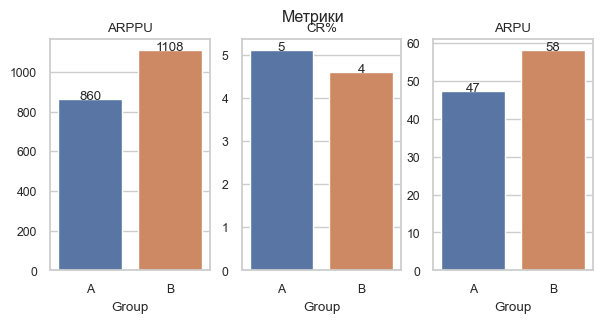

In [99]:
get_plots(metrics_dict)

Inspired by: KCM12